In [1]:
import ND_north_star.src.noise_generators.perlin_noise_generator as PNG

import ND_north_star.src.edge_detection.complex as ED_com
import ND_north_star.src.edge_detection.gradient_detection as ED_sim

import numpy as np
from scipy.ndimage import label


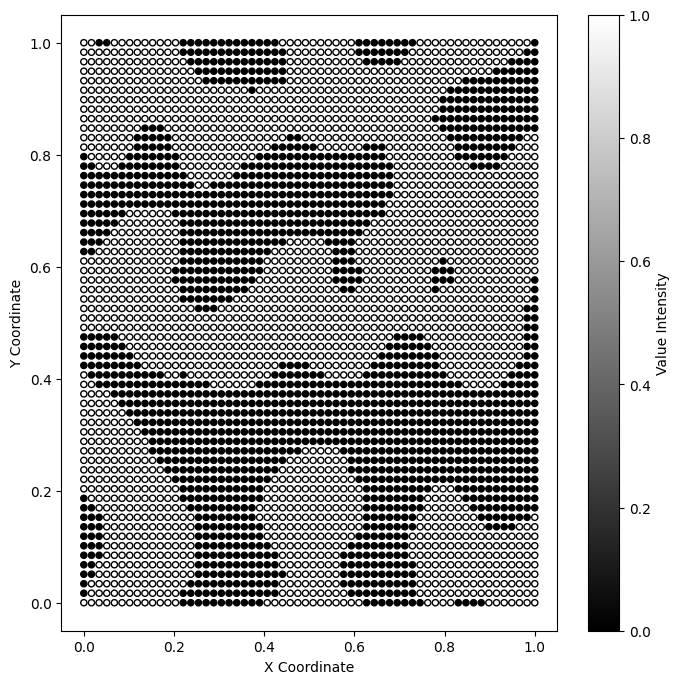

dict_keys(['features', 'values', 'resolution', 'coordinates', 'octaves', 'dimension'])


In [81]:
resolution = 60
dimensions = [resolution, resolution]


dataset = PNG.normalized_perlin_data(dimensions, 5)

# Plot perlin noise coord in x and y coordinates and with intensity values surrounded by a black outline
PNG.plot_perlin_2D_3D(dataset, 'black')

print(dataset.keys())

In [85]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def identify_boundary_points(data, labels, n_neighbors=5):
    boundary_points = []
    for idx, point in enumerate(data):
        if labels[idx] == 1:
            neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(data).kneighbors([point], return_distance=False)
            if any(labels[neighbor] == 0 for neighbor in neighbors[0]):
                boundary_points.append(point)
    return np.array(boundary_points)

# Example usage
data = dataset['features']  # Your N-dimensional data points
labels = dataset['values']  # Your corresponding labels (1 or 0)
boundary_points = identify_boundary_points(data, labels, 9)


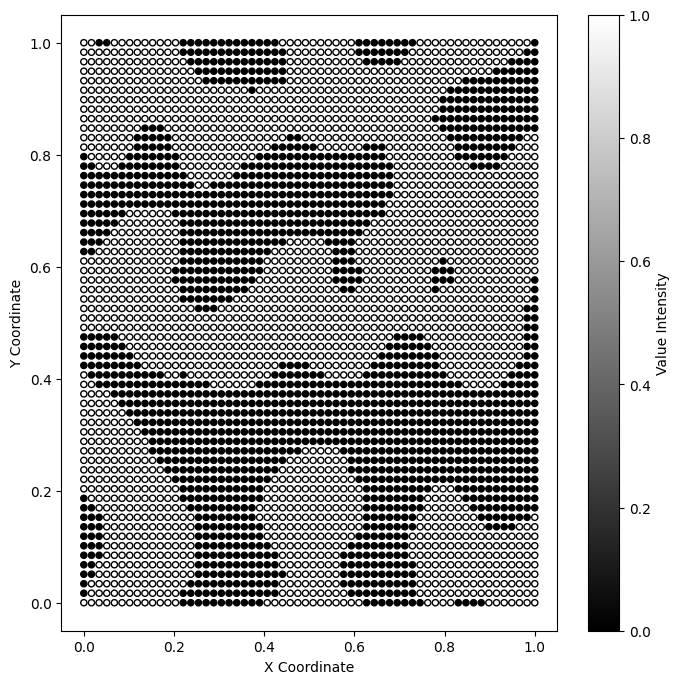

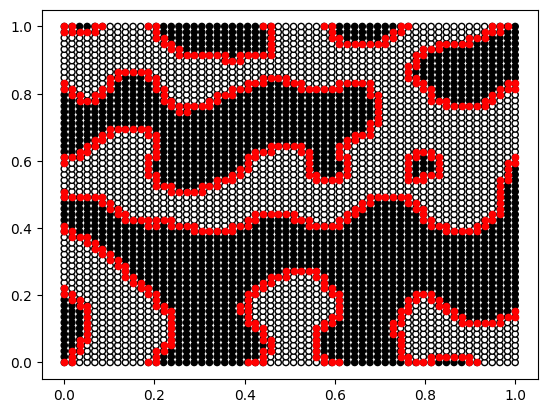

In [87]:
import numpy as np
import matplotlib.pyplot as plt

PNG.plot_perlin_2D_3D(dataset, 'black')

data = np.array(data)

if resolution < 100:
    marker_scale = resolution
else:
    marker_scale = 4*resolution

# Scatter plot
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='gray', s=1200/marker_scale, edgecolors='black')

plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='red', s=1200/marker_scale)




plt.show()


In [74]:
boundary_points.shape

(37, 2)

In [53]:
from sklearn.cluster import DBSCAN

def cluster_boundary_points(boundary_points, eps=0.5, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(boundary_points)
    return clustering.labels_

# Example usage
boundary_labels = cluster_boundary_points(boundary_points)


In [54]:
boundary_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [55]:
from scipy.interpolate import Rbf

def fit_splines_to_clusters(boundary_points, boundary_labels):
    unique_labels = np.unique(boundary_labels)
    splines = []
    for label in unique_labels:
        if label != -1:  # Skip noise points
            cluster_points = boundary_points[boundary_labels == label]
            # Assuming a 2D spline fit for simplicity; extend for N-dimensions as needed
            x = cluster_points[:, 0]
            y = cluster_points[:, 1]

            print(x, y)
            print(x.shape, y.shape)
            rbf = Rbf(x, y, function='multiquadric', smooth=0.1)
            splines.append(rbf)
    return splines

# Example usage
splines = fit_splines_to_clusters(boundary_points, boundary_labels)


[0.         0.         0.         0.02564103 0.02564103 0.02564103
 0.02564103 0.05128205 0.05128205 0.05128205 0.05128205 0.07692308
 0.1025641  0.12820513 0.15384615 0.17948718 0.20512821 0.23076923
 0.28205128 0.28205128 0.28205128 0.28205128 0.28205128 0.28205128
 0.30769231 0.30769231 0.30769231 0.30769231 0.30769231 0.30769231
 0.30769231 0.30769231 0.33333333 0.33333333 0.33333333 0.33333333
 0.35897436 0.35897436 0.38461538 0.38461538 0.41025641 0.41025641
 0.43589744 0.43589744 0.46153846 0.46153846 0.48717949 0.48717949
 0.51282051 0.51282051 0.51282051 0.51282051 0.51282051 0.53846154
 0.53846154 0.53846154 0.56410256 0.56410256 0.58974359 0.58974359
 0.61538462 0.61538462 0.64102564 0.64102564 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.69230769
 0.69230769 0.69230769 0.69230769 0.69230769 0.69230769 0.69230769
 0.69230769 0.69230769 0.69230769 0.69230769 0.69230769 0.69230769] [0.         0.33333333 0.51282051 0.02564103 0.35897436 0.461

In [56]:
print(splines)

for rbf in splines:
    print(rbf)

(1600, 2)
X shape: (40, 40), Y shape: (40, 40)
Number of points in meshgrid: 1600
Points shape (before RBF): (2, 1600)
(1600,) (1600,)


ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

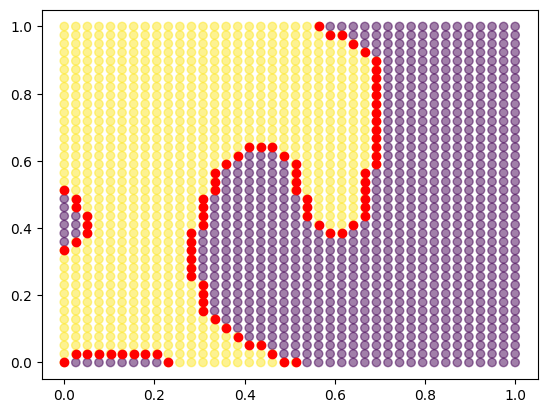

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf

def visualize_splines(data, labels, boundary_points, boundary_labels, splines, resolution):
    
    data = np.array(data)

    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.scatter(boundary_points[:, 0], boundary_points[:, 1], c='red')

    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    x = np.linspace(x_min, x_max, dataset['resolution'][0])
    y = np.linspace(y_min, y_max, dataset['resolution'][1])
    X, Y = np.meshgrid(x, y)

    # print(X)
    # print(Y)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    print(f"Number of points in meshgrid: {X.size}")

    for rbf in splines:

        # Flatten the meshgrid for RBF input
        points = np.vstack([X.ravel(), Y.ravel()])
        print(f"Points shape (before RBF): {points.shape}")

        # Perform RBF interpolation
        print(points[0].shape, points[1].shape)
        Z = rbf(points[0], points[1])
        print(f"RBF output shape: {Z.shape}")

        # Reshape the output back to the grid shape
        Z = Z.reshape(X.shape)
        print(f"Z shape after reshape: {Z.shape}")
    
    plt.show()

# Example usage
data = np.array(data)

print(data.shape)
visualize_splines(data, labels, boundary_points, boundary_labels, splines, resolution)


In [45]:
import numpy as np
from scipy.interpolate import Rbf

# Define the data points (coordinates)
x = np.random.rand(500)
y = np.random.rand(500)

# Define the values at the data points
z = np.sin(x * 10) * np.cos(y * 10)  # Example values based on a function


In [46]:
# Create the Rbf interpolator
rbf = Rbf(x, y, z, function='multiquadric', smooth=0.1)


In [49]:
# Define the grid
x_grid = np.linspace(0, 1, 40)
y_grid = np.linspace(0, 1, 40)
X, Y = np.meshgrid(x_grid, y_grid)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")

# Flatten the meshgrid for RBF input
points = np.vstack([X.ravel(), Y.ravel()])
print(f"Points shape (before RBF): {points.shape}")

# Perform RBF interpolation
Z = rbf(points[0], points[1])
print(f"RBF output shape: {Z.shape}")

# Reshape the output back to the grid shape
Z = Z.reshape(X.shape)
print(f"Z shape after reshape: {Z.shape}")


X shape: (40, 40), Y shape: (40, 40)
Points shape (before RBF): (2, 1600)
RBF output shape: (1600,)
Z shape after reshape: (40, 40)


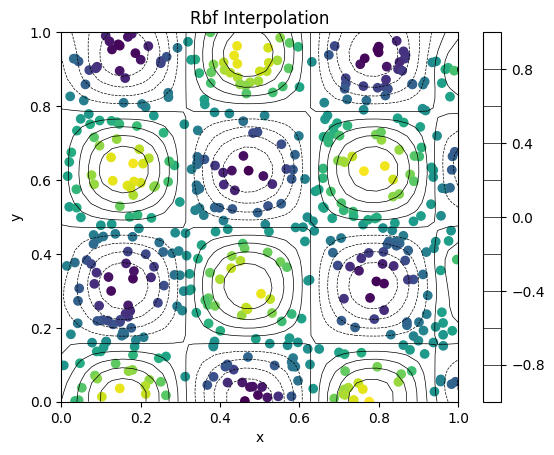

In [48]:
import matplotlib.pyplot as plt

plt.scatter(x, y, c=z, cmap='viridis', marker='o')
plt.contour(X, Y, Z, levels=10, linewidths=0.5, colors='k')
# plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title("Rbf Interpolation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
